In [5]:
import sys
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import to_date_period

idx = pd.IndexSlice

path = Path.cwd().parent / 'results' / 'periods'

In [6]:
dr = pd.date_range('2024-03-18', '2024-03-25', freq='30min')

In [7]:
cols = pd.MultiIndex.from_product(
    (('nodal', 'eso', 'national'),
    ('wholesale', 'balancing', 'cfd', 'congestion_rent'))
)

In [8]:
results = pd.DataFrame(
    columns=cols,
    index=dr,
    )

for ts in tqdm(results.index):
    date, period = to_date_period(ts)

    with open(path / f'{date}_{period}.json') as f:
        data = json.load(f)

    assert list(data)[0] == str(int(ts.timestamp()))

    for l, quant in results.columns:

        getname = quant + '_cost' if not 'congestion' in quant else quant
        results.loc[ts, idx[l, quant]] = data[list(data)[0]][l]['globals']['variables'][getname]


100%|██████████| 337/337 [00:08<00:00, 38.04it/s]


In [9]:
nice_p_name = {
    'wholesale': 'Wholesale Costs',
    'balancing': 'Constraint Management Costs',
    'cfd': 'CfD Payments',
    'congestion_rent': 'Intra-GB Congestion Rent',
}

nice_l_name = {
    'nodal': 'Nodal',
    'eso': 'Zonal',
    'national': 'National',
}

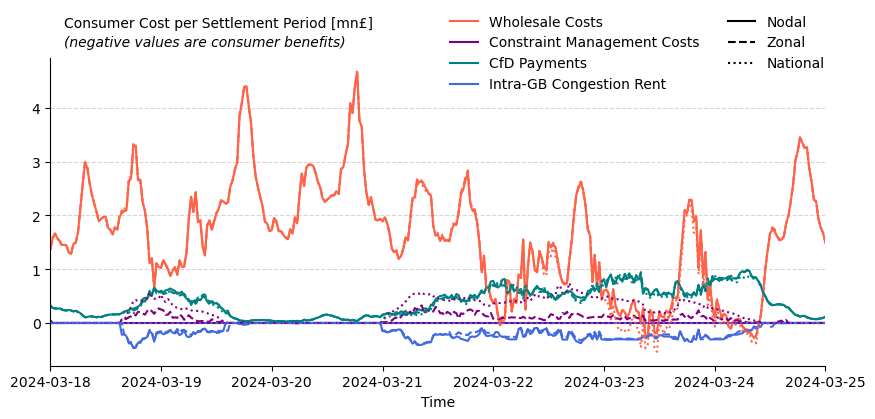

In [11]:
results

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

cmapper = {j
    'wholesale': 'tomato',
    'balancing': 'purple',
    'cfd': 'teal',
    'congestion_rent': 'royalblue',
}
lmapper = {
    'nodal': '-',
    'eso': '--',
    'national': ':',
}

lw = 1.5

for l, q in results.columns:
    ax.plot(results.index, results.loc[:, idx[l, q]].mul(1e-6), linestyle=lmapper[l], color=cmapper[q], lw=lw)

# for l, ls in lmapper.items():
#     ax.plot(results.index, results.loc[:, idx[l,:]].sum(axis=1).mul(1e-6), linestyle=ls, color='grey', lw=lw)

handles, labels = [], []

from matplotlib.lines import Line2D

for l, c in cmapper.items():
    handles.append(Line2D([0], [0], color=c, lw=lw, ls='-'))
    labels.append(nice_p_name[l])

# handles.append(Line2D([0], [0], color='grey', lw=lw, ls='-'))
# labels.append('Total')

for l, ls in lmapper.items():
    handles.append(Line2D([0], [0], color='k', lw=lw, ls=ls))
    labels.append(nice_l_name[l])

# handles.append(plt.Line2D([0], [0], color=c, lw=lw, linestyle='-'))

ax.legend(
    handles,
    labels,
    ncol=2,
    # bbox_to_anchor=(0.665, -0.15),
    bbox_to_anchor=(0.5, 0.85),
    frameon=False,
)
# ax.set_ylabel('Consumer Cost per Settlement Period [mn£]')
ax.set_xlabel('Time')

i = results.loc['2024-03-18 03:00:00':].index[0]
ax.text(
    i, 5.5,
    'Consumer Cost per Settlement Period [mn£]',
)
ax.text(
    i, 5.15,
    '(negative values are consumer benefits)',
    fontstyle='italic',
)

ax.grid(True, linestyle='--', alpha=0.5, axis='y')
ax.set_xlim(results.index[0], results.index[-1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('policy_cost.png', dpi=300, bbox_inches='tight')
plt.show()